This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/tree/main/wallaroo-model-cookbooks/computer-vision).

## Step 02: Detecting Objects Using resnet50

The following tutorial demonstrates how to use a trained mobilenet model deployed in Wallaroo to detect objects.  This process will use the following steps:

1. Create a Wallaroo workspace and pipeline.
1. Upload a trained resnet50 ML model and add it as a pipeline step.
1. Deploy the pipeline.
1. Perform an inference on a sample image.
1. Draw the detected objects, their bounding boxes, their classifications, and the confidence of the classifications on the provided image.
1. Review our results.

## Steps

### Import Libraries

The first step will be to import our libraries.  Please check with **Step 00: Introduction and Setup** and verify that the necessary libraries and applications are added to your environment.

In [11]:
import torch
import pickle
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

import numpy as np
import json
import requests
import time
import pandas as pd
from CVDemoUtils import CVDemo


import os
# For Wallaroo SDK 2023.1
os.environ["ARROW_ENABLED"]="True"

# used to display dataframe information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)


### Connect to Wallaroo

Now we connect to the Wallaroo instance.  If you are connecting from a remote connection, set the `wallarooPrefix` and `wallarooSuffix` and use them to connect.  If the connection is from within the Wallaroo instance cluster, then just `wl = wallaroo.Client()` can be used.

In [2]:
# Login through local service

wl = wallaroo.Client()

# SSO login through keycloak

# wallarooPrefix = "YOUR PREFIX"
# wallarooSuffix = "YOUR SUFFIX"

# wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}.api.{wallarooSuffix}", 
#                 auth_endpoint=f"https://{wallarooPrefix}.keycloak.{wallarooSuffix}", 
#                 auth_type="sso")

### Set Variables

The following variables and methods are used later to create or connect to an existing workspace, pipeline, and model.  This example has both the resnet model, and a post process script.

In [3]:
workspace_name = 'resnetworkspacetest'
pipeline_name = 'resnetnetpipelinetest'
model_name = 'resnet50'
model_file_name = 'models/frcnn-resnet.pt.onnx'

In [4]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name):
    try:
        pipeline = wl.pipelines_by_name(name)[0]
    except EntityNotFoundError:
        pipeline = wl.build_pipeline(name)
    return pipeline

### Create Workspace

The workspace will be created or connected to, and set as the default workspace for this session.  Once that is done, then all models and pipelines will be set in that workspace.

In [5]:
workspace = get_workspace(workspace_name)
wl.set_current_workspace(workspace)
wl.get_current_workspace()

{'name': 'resnetworkspacetest', 'id': 40, 'archived': False, 'created_by': '5df5ad39-ea9d-4824-922b-c30db35fc315', 'created_at': '2023-04-27T21:58:24.218632+00:00', 'models': [], 'pipelines': []}

### Create Pipeline and Upload Model

We will now create or connect to an existing pipeline as named in the variables above.

In [12]:
pipeline = get_pipeline(pipeline_name)

resnet_model = wl.upload_model(model_name, model_file_name, framework=Framework.ONNX).configure(batch_config="single")

### Deploy Pipeline

With the model uploaded, we can add it is as a step in the pipeline, then deploy it.  Once deployed, resources from the Wallaroo instance will be reserved and the pipeline will be ready to use the model to perform inference requests. 

In [13]:
pipeline.add_model_step(resnet_model)

pipeline.deploy()

Waiting for deployment - this will take up to 45s .................................. ok


name,resnetnetpipelinetest
created,2023-04-27 21:58:25.119144+00:00
last_updated,2023-04-27 22:00:10.287620+00:00
deployed,True
tags,
versions,"0d140100-fdf1-4795-a14f-d686f9cff9e3, 0a29104f-b09f-4f27-a484-5eab51eab397, 51ed6008-0f59-47ca-beda-1ec800276dac"
steps,resnet50


## Test the pipeline by running inference on a sample image

### Prepare input image

Next we will load a sample image and resize it to the width and height required for the object detector.

We will convert the image to a numpy ndim array and add it do a dictionary

In [15]:
#The size the image will be resized to
width = 640
height = 480

cvDemo = CVDemo()

imagePath = 'data/images/input/example/dairy_bottles.png'

# The image width and height needs to be set to what the model was trained for.  In this case 640x480.
tensor, resizedImage = cvDemo.loadImageAndResize(imagePath, width, height)

# get npArray from the tensorFloat
npArray = tensor.cpu().numpy()

#creates a dictionary with the wallaroo "tensor" key and the numpy ndim array representing image as the value.
# dictData = {"tensor": npArray.tolist()}

#creates a dictionary with the wallaroo "tensor" key and the numpy ndim array representing image as the value.
# dataframedata = pd.DataFrame(dictData)

dictData = {"tensor":[npArray]}
dataframedata = pd.DataFrame(dictData)

### Run Inference

With that done, we can have the model detect the objects on the image by running an inference through the pipeline, and storing the results for the next step.

**IMPORTANT NOTE**:  If necessary, add `timeout=60` to the `infer` method if more time is needed to upload the data file for the inference request.

In [18]:
startTime = time.time()
# pass the dataframe in 
infResults = pipeline.infer(dataframedata, dataset=["*", "metadata.elapsed"])
endTime = time.time()

display(infResults)

,time,in.tensor,out.3069,out.3070,out.output,check_failures,metadata.elapsed
0,2023-04-27 22:02:02.856,"[0.9372549057, 0.9529411793, 0.9490196109, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9490196109, 0.9490196109, 0.9529411793, 0.9529411793, 0.9490196109, 0.9607843161, 0.9686274529, 0.9647058845, 0.9686274529, 0.9647058845, 0.9568627477, 0.9607843161, 0.9647058845, 0.9647058845, 0.9607843161, 0.9647058845, 0.9725490212, 0.9568627477, 0.9607843161, 0.9176470637, 0.9568627477, 0.9176470637, 0.8784313798, 0.8941176534, 0.8431372643, 0.8784313798, 0.8627451062, 0.850980401, 0.9254902005, 0.8470588326, 0.9686274529, 0.8941176534, 0.8196078539, 0.850980401, 0.9294117689, 0.8666666746, 0.8784313798, 0.8666666746, 0.9647058845, 0.9764705896, 0.980392158, 0.9764705896, 0.9725490212, 0.9725490212, 0.9725490212, 0.9725490212, 0.9725490212, 0.9725490212, 0.980392158, 0.8941176534, 0.4823529422, 0.4627451003, 0.4313725531, 0.270588249, 0.2588235438, 0.2941176593, 0.3450980484, 0.3686274588, 0.4117647111, 0.4549019635, 0.4862745106, 0.5254902244, 0.5607843399, 0.6039215922, 0.6470588446, 0.6862745285, 0.721568644, 0.7450980544, 0.7490196228, 0.7882353067, 0.8666666746, 0.980392158, 0.9882352948, 0.9686274529, 0.9647058845, 0.9686274529, 0.9725490212, 0.9647058845, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, ...]","[0.99653566, 0.98834014, 0.97002465, 0.9696427, 0.96478045, 0.9603758, 0.954289, 0.94675404, 0.9465238, 0.9448496, 0.9361184, 0.91653466, 0.9133636, 0.8874816, 0.84405905, 0.82552564, 0.8232693, 0.81740046, 0.7956521, 0.78669065, 0.7731489, 0.7519371, 0.7360914, 0.7009188, 0.6932351, 0.65077204, 0.6324357, 0.5787764, 0.50234705, 0.5016376, 0.44628552, 0.42804396, 0.4253794, 0.3908623, 0.36836466, 0.34732383, 0.32950658, 0.31053737, 0.29076344, 0.28558335, 0.26680017, 0.2630283, 0.25444356, 0.24568672, 0.23536639, 0.23321976, 0.2261301, 0.22483175, 0.22332428, 0.21442994, 0.20122322, 0.19754866, 0.19439265, 0.19083941, 0.18713945, 0.17646068, 0.16628945, 0.16326296, 0.14825207, 0.1369454, 0.12920643, 0.12815331, 0.122357465, 0.121289544, 0.11628082, 0.11498651, 0.11184794, 0.11016109, 0.1095063, 0.1039153, 0.10385681, 0.097573824, 0.096320696, 0.095576234, 0.091599315, 0.09062039, 0.0826236, 0.08223515, 0.07993915, 0.079891644, 0.078758605, 0.07820142, 0.077379405, 0.07690225, 0.075934514, 0.07503403, 0.07482603, 0.068981, 0.06841148, 0.067641765, 0.06575022, 0.06490878, 0.061884128, 0.0601012, 0.05788715, 0.057176888, 0.056616377, 0.056017168, 0.054582983, 0.05366955]","[44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 86, 82, 44, 44, 44, 44, 44, 44, 84, 84, 44, 44, 44, 44, 86, 84, 44, 44, 44, 44, 44, 84, 44, 44, 84, 44, 44, 44, 44, 51, 44, 44, 44, 44, 44, 44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 86, 44, 44, 1, 84, 44, 44, 44, 44, 84, 47, 47, 84, 14, 44, 44, 53, 84, 47, 47, 44, 84, 44, 44, 82, 44, 44, 44]","[2.151101, 193.98317, 76.26535, 475.40298, 610.8225, 98.60633, 639.8868, 232.27054, 544.2867, 98.72654, 581.28845, 230.20494, 454.99344, 113.08567, 484.78464, 210.1282, 502.58884, 331.87665, 551.2269, 476.49182, 538.54254, 292.1205, 587.46545, 468.1288, 578.5417, 99.70756, 617.2247, 233.57082, 548.552, 191.84564, 577.30585, 238.47737, 459.83328, 344.29706, 505.42633, 456.71182, 483.47168, 110.56585, 514.0936, 205.00156, 262.1222, 190.3666, 323.4903, 405.20578, 511.6675, 104.53834, 547.01715, 228.23663, 75.39196, 205.62312, 168.49893, 453.44086, 362.50656, 173.1686, 398.66956, 371.82428, 490.42468, 337.627, 534.1234, 461.0242, 351.3856, 169.14899, 390.7583, 244.0699, 525.19824, 291.73898, 570.5553, 417.6439, 563.4224, 285.3889, 609.30853, 452.25943, 425.57935, 366.24915, 480.63535, 474.54, 154.538, 198.0377, 227.64284, 439.84412, 597.02893, 273.60458, 637.2067, 439.03214, 473.88763, 293.41992

### Draw the Inference Results

With our inference results, we can take them and use the Wallaroo CVDemo class and draw them onto the original image.  The bounding boxes and the confidence value will only be drawn on images where the model returned a 50% confidence rate in the object's identity.

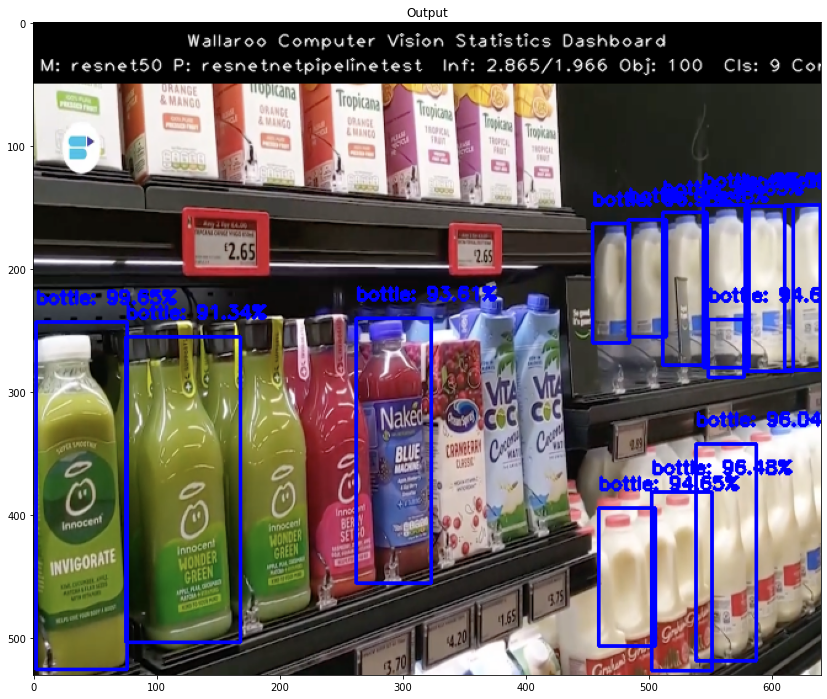

In [19]:
df = pd.DataFrame(columns=['classification','confidence','x','y','width','height'])
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2%}'.format

# Points to where all the inference results are
# boxList = infResults[0]["out.output"]
boxList = infResults.loc[0]["out.output"]



# outputs = results['outputs']
# boxes = outputs[0]

# # reshape this to an array of bounding box coordinates converted to ints
# boxList = boxes['Float']['data']
boxA = np.array(boxList)
boxes = boxA.reshape(-1, 4)
boxes = boxes.astype(int)

df[['x', 'y','width','height']] = pd.DataFrame(boxes)

classes = infResults.loc[0]["out.3070"]
confidences = infResults.loc[0]["out.3069"]

# classes = outputs[1]['Int64']['data']
# confidences = outputs[2]['Float']['data']

infResults = {
    'model_name' : model_name,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'boxes' : boxes,
    'classes' : classes,
    'confidences' : confidences,
    'confidence-target' : 0.90,
    'inference-time': (endTime-startTime),
    'onnx-time' : int(infResults.loc[0]["metadata.elapsed"][1]) / 1e+9,                
    'color':(255,0,0)
}

image = cvDemo.drawAndDisplayDetectedObjectsWithClassification(infResults)

### Extract the Inference Information

To show what is going on in the background, we'll extract the inference results create a dataframe with columns representing the classification, confidence, and bounding boxes of the objects identified.

In [20]:
idx = 0 
for idx in range(0,len(classes)):
    cocoClasses = cvDemo.getCocoClasses()
    df['classification'][idx] = cocoClasses[classes[idx]] # Classes contains the 80 different COCO classificaitons
    df['confidence'][idx] = confidences[idx]
df

,classification,confidence,x,y,width,height
0,bottle,99.65%,2,193,76,475
1,bottle,98.83%,610,98,639,232
2,bottle,97.00%,544,98,581,230
3,bottle,96.96%,454,113,484,210
4,bottle,96.48%,502,331,551,476
...,...,...,...,...,...,...
95,bottle,5.72%,556,287,580,322
96,refrigerator,5.66%,80,161,638,480
97,bottle,5.60%,455,334,480,349
98,bottle,5.46%,613,267,635,375


### Undeploy the Pipeline

With the inference complete, we can undeploy the pipeline and return the resources back to the Wallaroo instance.

In [21]:
pipeline.undeploy()

Waiting for undeployment - this will take up to 45s ..................................... ok


name,resnetnetpipelinetest
created,2023-04-27 21:58:25.119144+00:00
last_updated,2023-04-27 22:00:10.287620+00:00
deployed,False
tags,
versions,"0d140100-fdf1-4795-a14f-d686f9cff9e3, 0a29104f-b09f-4f27-a484-5eab51eab397, 51ed6008-0f59-47ca-beda-1ec800276dac"
steps,resnet50
